In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option("display.max_rows",20)
import matplotlib 
matplotlib.style.use('ggplot')

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score


# Import dataset

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

The Attributess include:
- **Age**: age of the patient [years]
- **Sex**: sex of the patient [M: Male, F: Female]
- **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- **RestingBP**: resting blood pressure [mm Hg]
- **Cholesterol**: serum cholesterol [mm/dl]
- **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
- **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
- **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
- **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- **HeartDisease**: output class [1: heart disease, 0: Normal]

#### Resources

- [Further dataset info on Kaggle.com](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

- [How do I plot it in Python?](https://python-graph-gallery.com)

In [2]:

# Uncomment the following line if you are running this notebook in Google Colab
## Google Colab 
# !wget https://raw.githubusercontent.com/agreco92/tutorial_ML/main/data/heart_failure.csv
# df = pd.read_csv("/content/heart_failure.csv")

## Github Codespaces
# df = pd.read_csv("./data/heart_failure.csv")

## Local
df = pd.read_csv("./data/heart_failure.csv")
df.head() # top 5 rows in the dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.shape # number of rows and columns in the dataset

(918, 12)

# Exploratory data analysis (EDA)

Exploratory Data Analysis (EDA) is the first step in any machine learning workflow, as it allows to uncover patterns, spot anomalies, and check assumptions related to our data.

The primary goal of EDA is to understand the data, gain insights, and inform model selection and feature engineering. Frequent steps in EDA are:

- **Data Summary**: Understanding the basic information about the data like number of rows/columns, data types of the columns, and basic statistical details of numerical columns.

- **Detect Missing Values**: Identifying missing data. This will require imputation or deletion, depending on the context (in this example, no missing values are expected)

- **Univariate Analysis**: This involves analyzing each variable in the dataset individually. For numerical variables, this usually involves understanding the central tendency and spread, as well as detection of outliers. For categorical variables, it involves understanding the count or frequency of categories.

- **Bivariate/Multivariate Analysis**: This involves analyzing the relationship between two or more variables, such as correlations among variables and their interactions

- **Data Visualization**: Graphical representations of data are a key part of EDA. Plots such as bar plots, histograms, scatter plots, and box plots can help us understand the data better.


## Column types

In [4]:
df.dtypes # list the type of data for each column of the dataframe

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Several categorical features are listed as "object" type. Here, we convert them to string to facilitate following steps.
The remaining columns are labelled as numerical.

In [5]:
string_col = df.select_dtypes(include="object").columns # detect columns of type 'object'
df[string_col] = df[string_col].astype("string") # convert 'object' columns to string type
string_col = string_col.to_list()

num_col=df.columns.to_list() # all columns are included in the num_col variables

# remove string columns using a loop
for col in string_col: 
    num_col.remove(col) 
num_col.remove("HeartDisease") # remove target variable from numerical columns

In [6]:
print(num_col)
print(string_col)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [8]:
string_col

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

### Numerical features analysis 

#### Univariate analysis

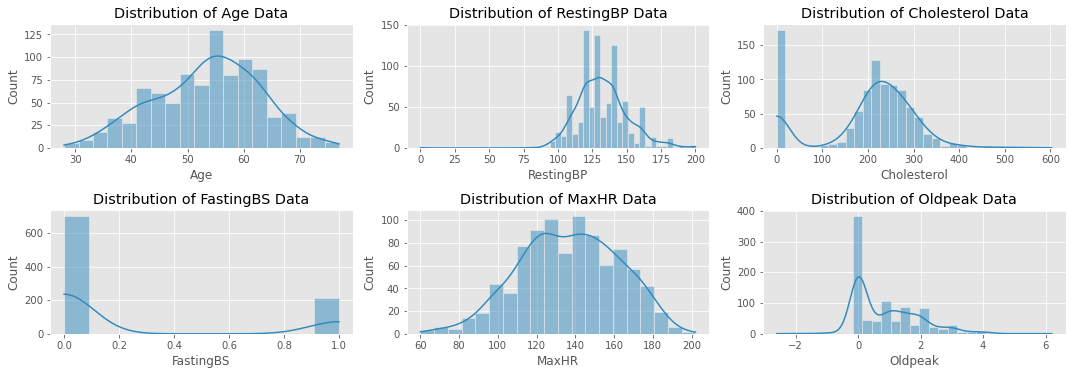

In [9]:
plt.figure(figsize=(15,10))
for i,col in enumerate(num_col,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

By looking at the plots, we can conclude that:
- numerical features span different ranges, thus require to be *scaled*
- The `FastingBS` column is actually categorical

#### Bivariate analysis

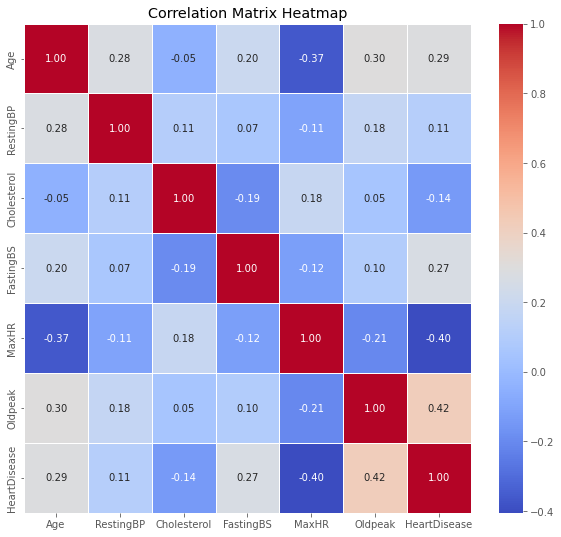

In [10]:
# Compute the correlation matrix
correlation_matrix = df.corr(method = 'spearman')

# plot as heatmap
plt.figure(figsize=(10, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

[]

<Figure size 1080x720 with 0 Axes>

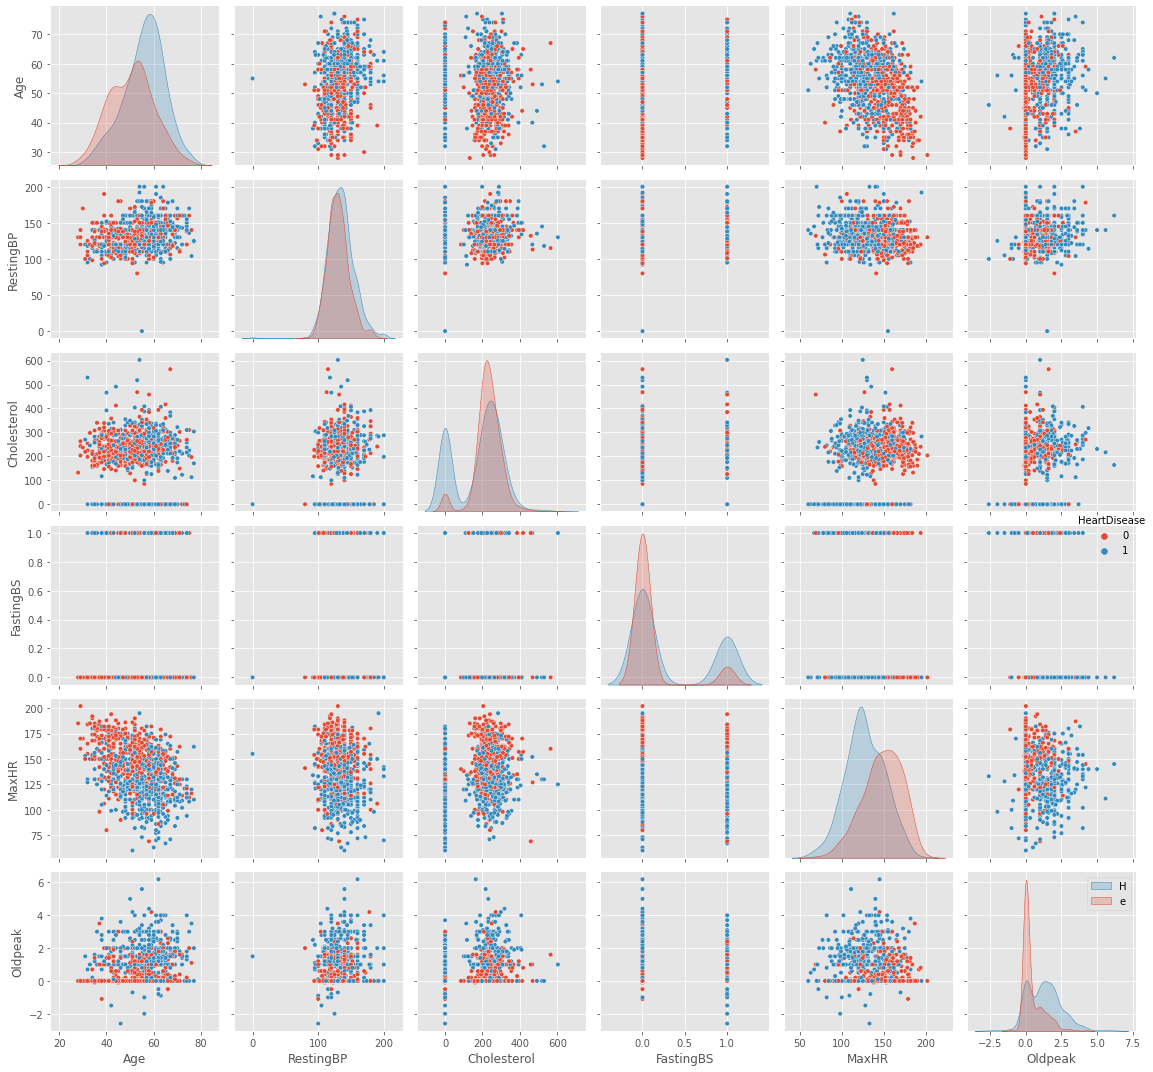

In [11]:
plt.figure(figsize=(15,10))
sns.pairplot(df[num_col + ['HeartDisease']],hue="HeartDisease",plot_kws={'s': 20} )
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

### Distribution of categorical features

In [12]:
# Shows the Distribution of Heat Diseases with respect to male and female
fig=px.histogram(df, 
                 x = "HeartDisease",
                 color = "Sex",
                 hover_data = df.columns,
                 title = "Distribution of Heart Diseases",
                 barmode = "group")
fig.show()

In [13]:
fig=px.histogram(df,
                 x = "ChestPainType",
                 color = "HeartDisease",
                 hover_data = df.columns,
                 title = "Types of Chest Pain"
                )
fig.show()

In [14]:
fig=px.histogram(df,
                 x = "ExerciseAngina", color = 'HeartDisease',
                 hover_data = df.columns,
                 title = "Distribution of ExerciseAngina")
fig.show()

# Pre-processing data

Numerical and categorical features require different preprocessing. Here, we distinguish between categorical and numerical features:

In [15]:
target_col = 'HeartDisease' 
feature_cols_categorical = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

feature_cols_numeric = df.columns.to_list()
feature_cols_numeric.remove(target_col) # remove target from numerical columns

# remove string columns using a loop
for categorical_column in feature_cols_categorical:
    feature_cols_numeric.remove(categorical_column)

## Scale numerical variables

In [16]:
feature_cols_numeric

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [17]:
scaler = preprocessing.RobustScaler(quantile_range = (1,99), unit_variance=True) # define scaling function
scaled_df_numeric = scaler.fit_transform(df[num_col]) # scale numerical columns 
scaled_df_numeric = pd.DataFrame(scaled_df_numeric, columns= num_col) # create dataframe with scaled values
df[num_col] = scaled_df_numeric.values # substitute original numerical features with scaled values
df[num_col].head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,-1.550899,0.547376,0.746259,0.0,1.453567,-0.620359
1,-0.553892,1.642128,-0.486199,0.0,0.769535,0.413573
2,-1.883234,0.000000,0.678417,0.0,-1.710078,-0.620359
3,-0.664671,0.437901,-0.101763,0.0,-1.282559,0.930539
4,0.000000,1.094752,-0.316595,0.0,-0.684031,-0.620359


## Encode categorical features

In [18]:
feature_cols_categorical

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'FastingBS']

### Encode ordinal categorical features

In [19]:
one_hot_features = ['ChestPainType', 'RestingECG'] # select categorical features for one-hot embedding

# classify the rest of the categorical features as ordinal
ordinal_features = feature_cols_categorical.copy()
for ft in one_hot_features:
    ordinal_features.remove(ft)


In [20]:
ordinal_features

['Sex', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

In [21]:
# ordinal encoding 
df_ordinal_categories = df[ordinal_features].apply(LabelEncoder().fit_transform)

`ST_slope`, despite being categorical, has a natural ordering (Down,Flat,Up). In the following section, I correct the encoding to reflect this ordering

In [22]:
print(df_ordinal_categories['ST_Slope'].value_counts()) 
print(df['ST_Slope'].value_counts())

1    460
2    395
0     63
Name: ST_Slope, dtype: int64
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: Int64


Encoding is not done properly! Let's fix it by explicitly setting the categories

In [23]:
# define encoding function
enc = OrdinalEncoder(categories=[['Down','Flat','Up']])  
X = [['Up'], ['Flat'], ['Down']]
enc.fit(X)

# apply encoding to ST_Slope
df_ordinal_categories['ST_Slope'] = np.ndarray.flatten(enc.transform([[s] for s in df['ST_Slope'].values]))
# substitute values in the dataframe
df[ordinal_features] = df_ordinal_categories

### Encode other categorical features

In [24]:
one_hot_features

['ChestPainType', 'RestingECG']

In [25]:
# save the dataset before one-hot encoding
df_original = df.copy()

In [26]:
df=pd.get_dummies(df,columns=one_hot_features,drop_first=True) # apply one-hot encoding on selected features
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,-1.550899,1,0.547376,0.746259,0,1.453567,0,-0.620359,2.0,0,1,0,0,1,0
1,-0.553892,0,1.642128,-0.486199,0,0.769535,0,0.413573,1.0,1,0,1,0,1,0
2,-1.883234,1,0.000000,0.678417,0,-1.710078,0,-0.620359,2.0,0,1,0,0,0,1
3,-0.664671,0,0.437901,-0.101763,0,-1.282559,1,0.930539,1.0,1,0,0,0,1,0
4,0.000000,1,1.094752,-0.316595,0,-0.684031,0,-0.620359,2.0,0,0,1,0,1,0


# "One-shot" learning
In this section, we will try to learn the target function using some of the algorithms learned so far. In order to have an idea of their generalization potential, we'll split the data and use the `_train` labels for training and the `_test`labels for estimating E_val

## Split in training and test data

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns.drop(target_col)], # input data
                                                    df[target_col].values, # target column
                                                    test_size=0.15,
                                                    random_state=42)

## Perceptron

In [28]:
from sklearn.linear_model import Perceptron
clf = Perceptron(penalty = 'none', random_state =1, max_iter=1000) # define a perceptron classifier
clf = clf.fit(X_train, Y_train) # fit the classifier using the training data

#### Testing error

***Exercise***: Compute *recall* and *precision* for the '1' label of the trained perceptron, thus compute the *f1 score* (see slides)

Let's define a function that displays the confusion matrix for a classifier and quantifies its accuracy:

In [30]:
def evaluate_classifier(clf,X_test,Y_test, class_label = ["No Disease", "Disease"]):
    # Make predictions
    Y_pred = clf.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)

    # Create a DataFrame for the confusion matrix
    df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, linewidths=2, fmt='d')
    plt.title("Confusion Matrix", fontsize=25)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Calculate accuracy
    accuracy = accuracy_score(Y_test, Y_pred)
    print("Accuracy: " + f"{accuracy:.3f}")
    print("F1 score: " + f"{f1_score(Y_test, Y_pred):.3f}")

    return accuracy

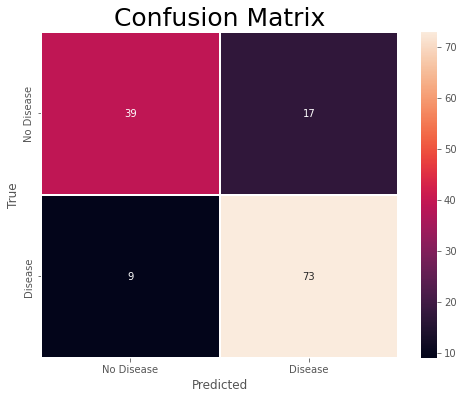

Accuracy: 0.812
F1 score: 0.849


0.8115942028985508

In [31]:
Y_pred=clf.predict(X_test) # predict the class using the trained classifier

evaluate_classifier(clf,X_test,Y_test)

## Logistic regression

***Exercise***: Compute *recall* and *precision* for the '1' label of the trained perceptron, thus compute the *f1 score* (see slides)

#### Testing error

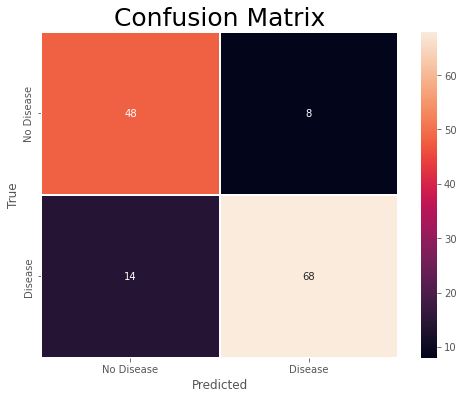

Accuracy: 0.841
F1 score: 0.861


0.8405797101449275

In [33]:
Y_pred=clf.predict(X_test)

evaluate_classifier(clf, X_test, Y_test)

## Multi-layer perceptron / Neural network (exercise)

***Exercise***: Using the known rule of thumb N_param <= 0.1* N_training points, design a neural network that outperforms the logistic classifier in the classification task. 

*Hint*: You can choose to disregard some features in order to increase the number of available parameters.

#### Testing error

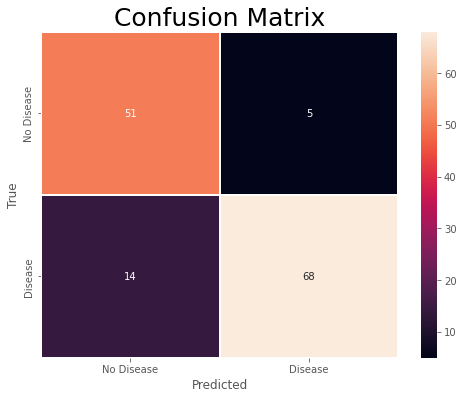

Accuracy: 0.862
F1 score: 0.877


0.8623188405797102

In [35]:
Y_pred=clf.predict(X_test)

evaluate_classifier(clf, X_test, Y_test)

## Train the best model on full data

***Exercise***: Train a neural network using the full dataset and report the training error

# Cross-validation

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


## Estimate E_out using cross-validation

0.8342809364548496
0.05428657758520127


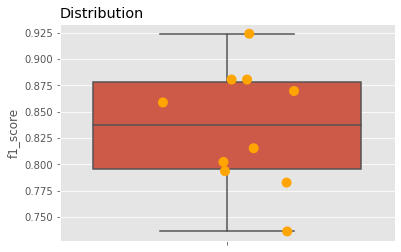

In [38]:

X = df[df.columns.drop(target_col)]
y = df[target_col].values

kf = model_selection.StratifiedKFold(n_splits = 10)
kf_split = kf.split(X = X, y = y)

scores_log=[]

for fold , (tran_index, validation_index) in enumerate(kf_split):
    
    # define training set 
    # hint: use df.loc[index, columns] to slice the dataframe
    X_train = X.loc[tran_index, :]
    y_train = y[tran_index]
    
    # define validation set
    X_valid = X.loc[validation_index, :]
    y_valid = y[validation_index]
    
    # instantiate logistic regressor
    clf = LogisticRegression(random_state =1, 
                             max_iter=1000, penalty = 'none')
    # train logistic regressor
    clf.fit(X_train,y_train)
    
    # predict validation set
    y_pred = clf.predict(X_valid)
    
    # compute f1_score (function: f1_score)
    score = accuracy_score(y_valid,y_pred)
    
    # add score to scores log
    scores_log.append(score)

print(np.mean(scores_log))
print(np.std(scores_log))


df_plot = pd.DataFrame({ 'accuracy' : scores_log})

# boxplot
ax = sns.boxplot(y='accuracy', data=df_plot)
# add stripplot
ax = sns.stripplot( y='accuracy', data=df_plot, color="orange", jitter=0.2, size=10)

# add title
plt.title("Validation accuracy", loc="left")

# show the graph
plt.show()

## Hyperparameter estimation using cross-validation

***Exercise***: Use cross validation to select both the degree of polynomial expansion and the regularization parameter to maximize the performance of a logistic regression model

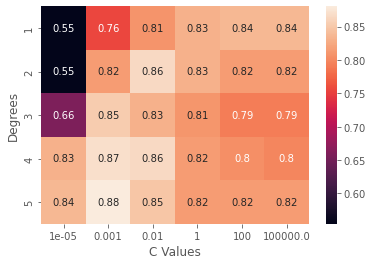

In [42]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the matrix using seaborn heatmap
sns.heatmap(score_matrix, xticklabels=C_values, yticklabels=degrees, 
            annot=True)
plt.xlabel('C Values')
plt.ylabel('Degrees')
# Show the plot
plt.show()